In [1]:
config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import nglview as nv
import pyemma
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from openmmBridge import OpenMMEnergy
import torch
import networkx as nx
from pathlib import Path
plt.rcParams.update({'font.size': 14})

In [22]:
def get_bond_array(trj, bond_type):
    #bond_set = set(bond_type.split('-'))
    bond_set = set(bond_type)
    bond_array = list()
    for bond in trj.top.bonds:
        a1 = bond.atom1
        a2 = bond.atom2
        true_bonds = set([a1.element.symbol, a2.element.symbol])
        if true_bonds == bond_set:
            bond_array.append([a1.index, a2.index])
    return np.array(bond_array)

def get_all_bonds(trj):
    bond_array = list()
    bond_array_set = list()
    for bond in trj.top.bonds:
        a1 = bond.atom1.element.symbol
        a2 = bond.atom2.element.symbol
        if set([a1, a2]) not in bond_array_set:
            bond_array_set.append(set([a1, a2]))
            bond_array.append([a1, a2])
    return np.array(bond_array)

def get_angle_inds(trj):
    index_dict = {a.index:a.element.symbol for a in trj.top.atoms}
    G = trj.top.to_bondgraph()
    A = nx.to_numpy_array(G)
    N = A.shape[0]
    angs_inds = list()
    angs_inds_names = list()
    for i in range(N):
        J = np.where(A[i] == 1.)[0]
        for j in J:
            K = np.where(A[j] == 1.)[0]
            for k in K:
                if (i!=j) and (i!=k) and (j!=k):
                    if ([i, j, k] not in angs_inds_names) and ([k, j, i] not in angs_inds_names):
                        angs_inds.append((i, j, k))
    return np.array(angs_inds)

def get_all_angles(trj):
    index_dict = {a.index:a.element.symbol for a in trj.top.atoms}
    angle_inds = get_angle_inds(trj)
    angle_names = np.vectorize(index_dict.get)(angle_inds)
    angle_array = list()
    for i, angle in enumerate(angle_names):
        if i == 0:
            angle_array.append(angle)
            continue
        cond1 = ~np.any(np.all(angle==angle_array, axis=1))
        cond2 = ~np.any(np.all(angle[::-1]==angle_array, axis=1))
        if cond1 and cond2:
            angle_array.append(angle)
    return np.array(angle_array)

def get_angles(trj, angle_type):
    #angle_type = angle_type.split('-')
    angle_inds = get_angle_inds(trj)
    index_dict = {a.index:a.element.symbol for a in trj.top.atoms}
    symbol_angles = np.vectorize(index_dict.get)(angle_inds)
    ang_mask = np.where(np.logical_or(np.all((symbol_angles == angle_type), axis=1), 
                                      np.all((symbol_angles == angle_type[::-1]), axis=1)))[0]
    return angle_inds[ang_mask]
def plot_bond(real_trj, fake_trj, bond_type, ax=None):
    
    bonds = get_bond_array(real_trj[0], bond_type=bond_type)
    
    if isinstance(real_trj, list):
        lengths_real = list()
        for trj in real_trj:
            lengths_real.append(md.compute_distances(trj, bonds))
        lengths_real = np.concatenate(lengths_real)
    else:
        lengths_real = md.compute_distances(real_trj, bonds)
        
    if isinstance(fake_trj, list):
        lengths_fake = list()
        for trj in fake_trj:
            lengths_fake.append(md.compute_distances(trj, bonds))
        lengths_fake = np.concatenate(lengths_fake)
    else:
        lengths_fake = md.compute_distances(fake_trj, bonds)
        
    min_val = 0.08#lengths_real.min()
    max_val = 0.19#lengths_real.max()
    bins=np.linspace(min_val, max_val, 100)
    if ax is None:
        plt.hist(lengths_real.flatten(), bins=bins, label='Ground Truth', histtype='stepfilled',edgecolor='black', density=True);
        plt.hist(lengths_fake.flatten(), alpha=0.5, bins=bins, label='Baseline', histtype='stepfilled',edgecolor='black', density=True);
        plt.legend()
        plt.title(f"{bond_type[0]}-{bond_type[1]}",fontsize=15)
    ax.hist(lengths_real.flatten(), bins=bins, label='Test set (ground truth)', histtype='stepfilled',edgecolor='black', density=True);
    ax.hist(lengths_fake.flatten(), alpha=0.5, bins=bins, label='Test set (reconstructed)', histtype='stepfilled',edgecolor='black', density=True);
    ax.legend()
    ax.set_title(f"{bond_type[0]}-{bond_type[1]}")
    ax.set_xlabel('nm')
def plot_angles(real_trj, fake_trj, angle_type, ax=None):
    angles = get_angles(real_trj[0], angle_type=angle_type)
    
    if isinstance(real_trj, list):
        angles_real = list()
        for trj in real_trj:
            angles_real.append(md.compute_angles(trj, angles))
        angles_real = np.concatenate(angles_real)
    else:
        angles_real = md.compute_angles(real_trj, angles)
        
    if isinstance(fake_trj, list):
        angles_fake = list()
        for trj in fake_trj:
            angles_fake.append(md.compute_angles(trj, angles))
        angles_fake = np.concatenate(angles_fake)
    else:
        angles_fake = md.compute_angles(angles_fake, angles)
    
    
    min_val = angles_real.min()
    max_val = angles_real.max()
    bins=np.linspace(min_val, max_val, 100)
    if ax is None:
        plt.hist(angles_real.flatten(), bins=bins, label='Atomistic reference', histtype='stepfilled',edgecolor='black', density=True);
        plt.hist(angles_fake.flatten(), alpha=0.5, bins=bins, label='CG reconstructed', histtype='stepfilled',edgecolor='black', density=True);
        plt.legend()
        plt.set_title(f"{angle_type[0]}-{angle_type[1]}-{angle_type[2]}",fontsize=15)
    ax.hist(angles_real.flatten(), bins=bins, label='Atomistic reference', histtype='stepfilled',edgecolor='black', density=True);
    ax.hist(angles_fake.flatten(), alpha=0.5, bins=bins, label='CG reconstructed', histtype='stepfilled',edgecolor='black', density=True);
    #ax.legend()
    ax.set_title(f"{angle_type[0]}-{angle_type[1]}-{angle_type[2]}")
    ax.set_xlabel(r'$\theta$')
def get_V(trj, atom=None):
    xyz = trj.xyz * 10.
    if atom is not None:
        mask = np.fromiter((a.element.symbol==atom for a in real_trj.top.atoms), dtype=np.bool)
        xyz = xyz[:, mask]
        v2 = np.power((xyz[1:] - xyz[:-1]) / 2., 2).sum(axis=-1)
    else:
        v2 = np.power((xyz[1:] - xyz[:-1]) / 2., 2).sum(axis=-1)
    V = np.mean(v2, axis=1)
    return V
def plot_v(real_trj, fake_trj, atom=None, ax=None):
    if isinstance(real_trj, list):
        V_real = list()
        for trj in tqdm(real_trj):
            V_real.append(get_V(trj, atom))
        V_real = np.concatenate(V_real)
    else:
        V_real = get_V(real_trj, atom)
            
    if isinstance(fake_trj, list):
        V_fake = list()
        for trj in tqdm(fake_trj):
            V_fake.append(get_V(trj, atom))
        V_fake = np.concatenate(V_fake)
    else:
        V_fake = get_V(fake_trj, atom)
        
    bins=np.linspace(0,40,100)
    if ax is not None:
        ax.hist(V_real, bins=bins, label='Test set (ground truth)', histtype='stepfilled',edgecolor='black', density=True)
        ax.hist(V_fake, alpha=0.5, bins=bins, label='Test set (reconstructed)', histtype='stepfilled',edgecolor='black', density=True)
        ax.legend()
        if atom is not None:
            ax.set_title(atom, fontsize=14)
        ax.set_xlabel('velocity (angstrom / ps)')
    else:
        plt.hist(V_real, bins=bins, label='Test set (ground truth)', histtype='stepfilled',edgecolor='black', density=True)
        plt.hist(V_fake, alpha=0.5, bins=bins, label='Test set (reconstructed)', histtype='stepfilled',edgecolor='black', density=True)
        plt.legend()
        if atom is not None:
            plt.title(atom, fontsize=14)

In [4]:
def FES_plot(x, y, ax, cbar=False, cax=None, levels=15, nbins=60): pyemma.plots.plot_free_energy(x, y, levels=levels, nbins=nbins, ax=ax, cbar=cbar, cax=cax, )

In [5]:
fake_trj_fname = sorted([str(p) for p in Path('CLN_cg2aa_hallucinate').glob('hallucinated_*.dcd')])
fake_top_fname = '../midway3_c2f/chig_new/AA.pdb'

real_trj_fname = sorted([str(p) for p in Path('/project2/andrewferguson/Kirill/midway3_c2f/chig_new/AA_xtc/').glob('*.xtc')])
real_top_fname = '../midway3_c2f/chig_new/AA.pdb'

In [6]:
real_trj = list()
for trj_fname in tqdm(real_trj_fname):
    real_trj.append(md.load(trj_fname, top=real_top_fname).center_coordinates())

In [7]:
fake_trj = list()
for trj_fname in tqdm(fake_trj_fname):
    fake_trj.append(md.load(trj_fname, top=fake_top_fname).center_coordinates())

In [8]:
#fake_trj = md.load(fake_trj_fname, top=fake_top_fname)

In [9]:
#md.join(real_trj)

In [10]:
#real_trj = md.load(real_trj_fname, top=real_top_fname)#.center_coordinates()
#fake_trj = md.load(fake_trj_fname, top=fake_top_fname)#.center_coordinates()

In [11]:
ELoss = OpenMMEnergy(real_trj[0].n_atoms * 3, real_top_fname, mol_name='CLN', tops_fname='/project2/andrewferguson/Kirill/midway3_c2f/charmm_tops')

Process Worker-31:
Process Worker-25:
Process Worker-29:
Process Worker-19:
Process Worker-34:
Process Worker-40:
Process Worker-22:
Process Worker-2:
Process Worker-12:
Process Worker-16:
Process Worker-3:
Process Worker-38:
Process Worker-14:
Process Worker-28:
Process Worker-35:
Process Worker-36:
Process Worker-9:
Process Worker-21:
Process Worker-11:
Process Worker-26:
Process Worker-20:
Process Worker-13:
Process Worker-30:
Process Worker-24:
Process Worker-37:
Process Worker-27:
Process Worker-10:
Process Worker-8:
Process Worker-15:
Process Worker-18:
Process Worker-32:
Process Worker-39:
  File "/project2/andrewferguson/Kirill/c2f_vae_final/openmmBridge.py", line 395, in run
    for task in iter(self._task_queue.get, None):
Traceback (most recent call last):
Traceback (most recent call last):
Process Worker-17:
Traceback (most recent call last):
Process Worker-7:
Process Worker-1:
Process Worker-33:
  File "/project2/andrewferguson/Kirill/conda_env/lib/python3.7/multiprocessin

  File "/project2/andrewferguson/Kirill/conda_env/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/project2/andrewferguson/Kirill/c2f_vae_final/openmmBridge.py", line 395, in run
    for task in iter(self._task_queue.get, None):
  File "/project2/andrewferguson/Kirill/c2f_vae_final/openmmBridge.py", line 395, in run
    for task in iter(self._task_queue.get, None):
  File "/project2/andrewferguson/Kirill/conda_env/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/project2/andrewferguson/Kirill/c2f_vae_final/openmmBridge.py", line 395, in run
    for task in iter(self._task_queue.get, None):
  File "/project2/andrewferguson/Kirill/conda_env/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/project2/andrewferguson/Kirill/c2f_vae_final/openmmBridge.py", line 395, in run
    for task in iter(self._task_queue.get, None):
  File "/project2/andrewferguson/Kirill/conda_env/

  File "/project2/andrewferguson/Kirill/conda_env/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/project2/andrewferguson/Kirill/conda_env/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/project2/andrewferguson/Kirill/conda_env/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/project2/andrewferguson/Kirill/conda_env/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/project2/andrewferguson/Kirill/conda_env/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/project2/andrewferguson/Kirill/conda_env/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/project2/andrewferguson/Kirill/conda_env/lib/python3.7/multiprocessing/synchronize.py", l

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/project2/andrewferguson/Kirill/conda_env/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/project2/andrewferguson/Kirill/conda_env/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/project2/andrewferguson/Kirill/conda_env/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/project2/andrewferguson/Kirill/conda_env/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt


In [12]:
real_energies = list()
for trj in tqdm(real_trj):
    real_energies.append(ELoss.energy(torch.Tensor(trj.xyz.reshape(-1, trj.n_atoms * 3))).numpy().flatten())

fake_energies = list()
for trj in tqdm(fake_trj):
    fake_energies.append(ELoss.energy(torch.Tensor(trj.xyz.reshape(-1, trj.n_atoms * 3))).numpy().flatten())

In [13]:
real_energies = np.concatenate(real_energies)
fake_energies = np.concatenate(fake_energies)

In [14]:
#real_energies = ELoss.energy(torch.Tensor(real_trj.xyz.reshape(-1, real_trj.n_atoms * 3))).numpy().flatten()
#fake_energies = ELoss.energy(torch.Tensor(fake_trj.xyz.reshape(-1, fake_trj.n_atoms * 3))).numpy().flatten()

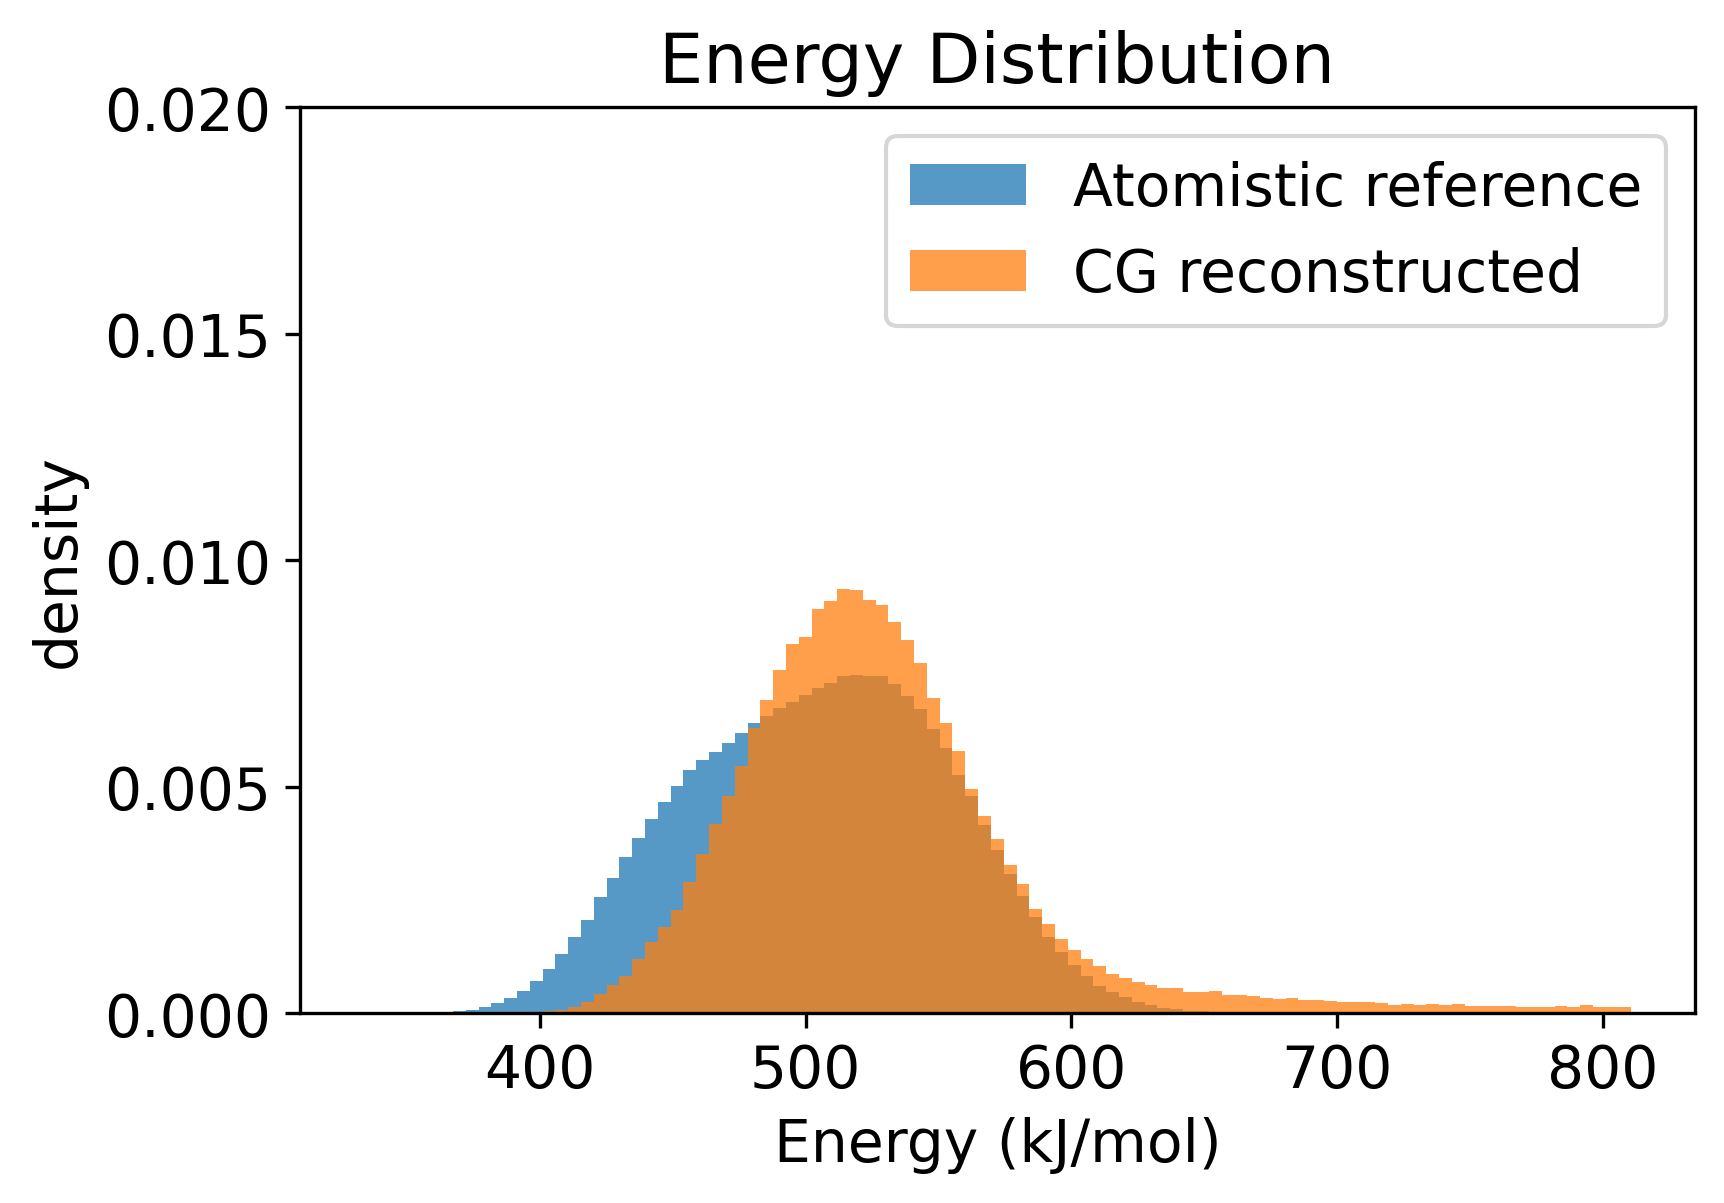

In [15]:
plt.figure(dpi=300)
bins = np.linspace(real_energies.min(),real_energies.max() * 12./11, 100)
plt.hist(real_energies, bins=bins, alpha=0.75, label='Atomistic reference', density=True);
plt.hist(fake_energies, bins=bins, alpha=0.75, label='CG reconstructed', density=True);
plt.xlabel('Energy (kJ/mol)')
plt.ylabel('density')
plt.title('Energy Distribution')
plt.ylim(0, 0.02)
plt.legend()
plt.show()

In [16]:
all_bonds = get_all_bonds(real_trj[0])

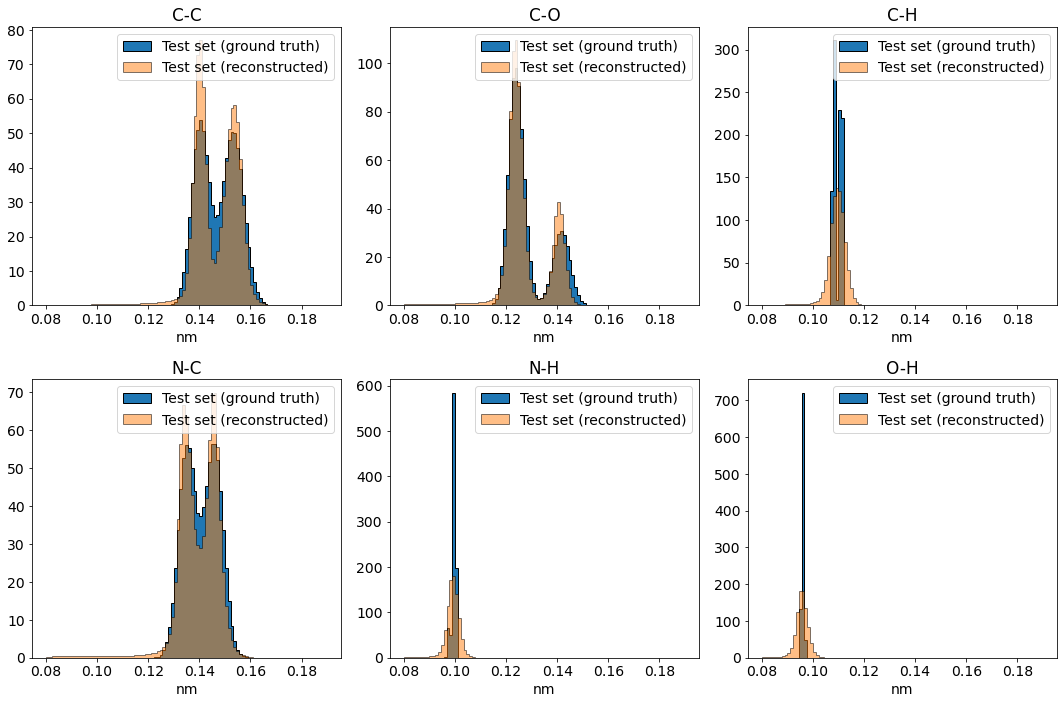

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, bond in enumerate(all_bonds):
    plot_bond(real_trj, fake_trj, bond, axes[i])
plt.tight_layout()
plt.show()
#plt.savefig('bond.pdf', transparent=True, bbox_inches="tight")

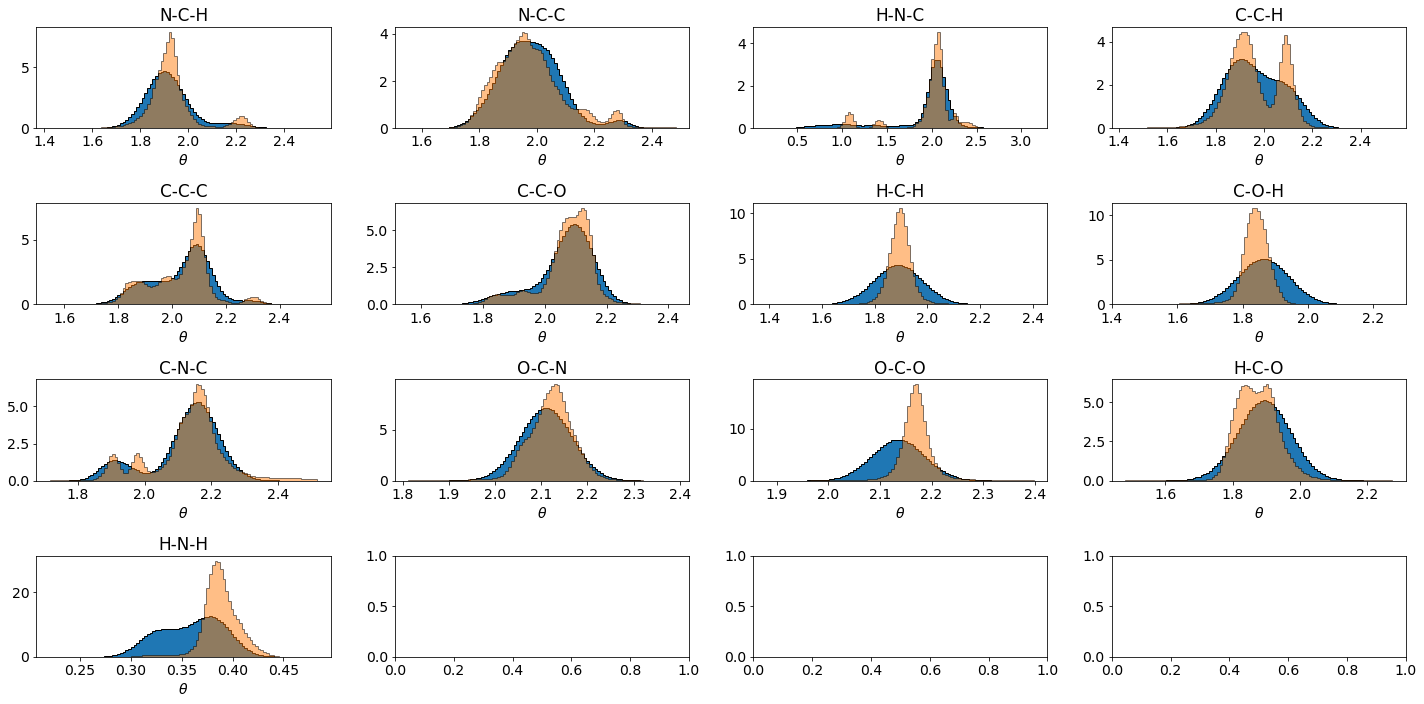

In [18]:
all_angles = get_all_angles(real_trj[0])
fig, axes = plt.subplots(4, 4, figsize=(20, 10))
axes = axes.flatten()
for i, angle in enumerate(all_angles):
    plot_angles(real_trj, fake_trj, angle, axes[i])
plt.tight_layout()
plt.show()
#plt.savefig('angle.pdf', transparent=True, bbox_inches="tight")

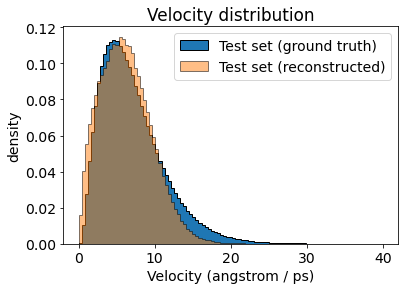

In [23]:
plot_v(real_trj, fake_trj)
plt.title("Velocity distribution")
plt.xlabel('Velocity (angstrom / ps)')
plt.ylabel('density')
plt.show()
#plt.savefig('vel_total.pdf', transparent=True, bbox_inches="tight")